In [1]:
# following codes were tested with Anaconda environment online.

import matplotlib.pyplot as plt
import numpy as np
import os
import PIL

In [2]:
from time import process_time

In [3]:
import tensorflow as tf

In [4]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [5]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9559119798468036221
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 182566712618278375
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 15851235251826062030
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_GPU:1"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 15792628383059168774
physical_device_desc: "device: XLA_GPU device"
]


In [6]:
# tf.test.gpu_device_name()
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:1', device_type='XLA_GPU')]

In [7]:
from platform import python_version

print(python_version())

3.7.9


In [8]:
keras.__version__

'2.4.0'

In [9]:
tf.__version__

'2.3.0'

In [10]:
img_height=400
img_width=518
batch_size=32

In [11]:
train_ds=tf.keras.preprocessing.image_dataset_from_directory(
    '../data',labels='inferred',label_mode='int',
    validation_split=0.2, subset='training',
    seed=123,color_mode='grayscale',
    image_size=(img_height,img_width),
    batch_size=batch_size
    )

Found 280 files belonging to 2 classes.
Using 224 files for training.


In [12]:
val_ds=tf.keras.preprocessing.image_dataset_from_directory(
    '../data',labels='inferred',label_mode='int',
    validation_split=0.2, subset='validation',
    seed=123,color_mode='grayscale',
    image_size=(img_height,img_width),
    batch_size=batch_size
    )

Found 280 files belonging to 2 classes.
Using 56 files for validation.


In [13]:
class_names = train_ds.class_names
print(class_names)

['par1', 'wt']


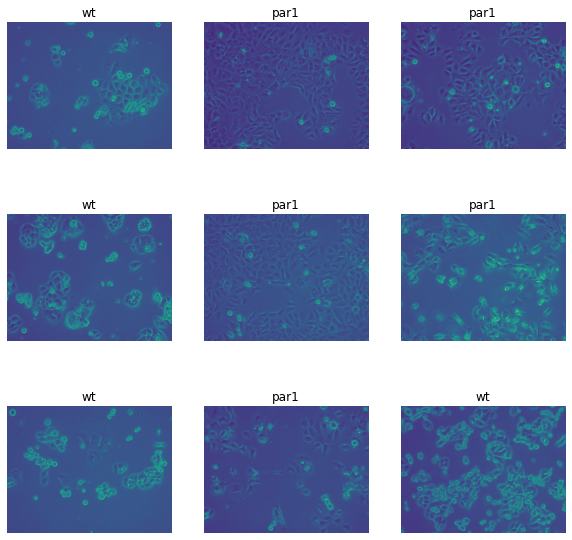

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))

for images,labels in train_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [15]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 400, 518, 1)
(32,)


In [16]:
# Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. 
# These are two important methods you should use when loading data.

# Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch. 
# This will ensure the dataset does not become a bottleneck while training your model. 
# If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk 
# cache.

# Dataset.prefetch() overlaps data preprocessing and model execution while training.

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds=val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [17]:
# This is for normalization foorr RBG channel. We used Grayscale, so search whether this is required 
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [23]:
# Create the model (Note that below model does not contain drop out)

num_classes = 2

# model = Sequential([
#   layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 1)),
#   layers.Conv2D(16, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(32, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(64, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Flatten(),
#   layers.Dense(128, activation='relu'), 
#   layers.Dense(num_classes)
# ])

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 1)),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
#   layers.Dense(256, activation='relu'), #original 128
  layers.Dense(256, activation='softmax'), #original 128
  layers.Dense(num_classes)
])

In [24]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 400, 518, 1)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 400, 518, 32)      320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 200, 259, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 200, 259, 64)      18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 100, 129, 64)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 100, 129, 128)     73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 50, 64, 128)      

In [26]:
t0_start=process_time()

epochs=100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)
t0_stop=process_time()
print("Elapsed time: ", t0_stop, t0_start)
print("Time for total "+str(epochs) +" epochs : "+str((t0_stop-t0_start)/600) +" min.")

Epoch 1/100
7/7 [==============================] - 17s 2s/step - loss: 0.6916 - accuracy: 0.5179 - val_loss: 0.7047 - val_accuracy: 0.3571
Epoch 2/100
7/7 [==============================] - 14s 2s/step - loss: 0.6888 - accuracy: 0.5357 - val_loss: 0.7150 - val_accuracy: 0.3571
Epoch 3/100
7/7 [==============================] - 14s 2s/step - loss: 0.6880 - accuracy: 0.5357 - val_loss: 0.6966 - val_accuracy: 0.3571
Epoch 4/100
7/7 [==============================] - 14s 2s/step - loss: 0.6797 - accuracy: 0.5357 - val_loss: 0.6859 - val_accuracy: 0.4821
Epoch 5/100
7/7 [==============================] - 14s 2s/step - loss: 0.6527 - accuracy: 0.7143 - val_loss: 0.6737 - val_accuracy: 0.6429
Epoch 6/100
7/7 [==============================] - 14s 2s/step - loss: 0.6305 - accuracy: 0.7679 - val_loss: 0.6403 - val_accuracy: 0.7321
Epoch 7/100
7/7 [==============================] - 14s 2s/step - loss: 0.5835 - accuracy: 0.9286 - val_loss: 0.6299 - val_accuracy: 0.7679
Epoch 8/100
7/7 [==========

7/7 [==============================] - 14s 2s/step - loss: 0.2806 - accuracy: 1.0000 - val_loss: 0.6890 - val_accuracy: 0.6429
Epoch 60/100
7/7 [==============================] - 14s 2s/step - loss: 0.2777 - accuracy: 1.0000 - val_loss: 0.6897 - val_accuracy: 0.6429
Epoch 61/100
7/7 [==============================] - 14s 2s/step - loss: 0.2749 - accuracy: 1.0000 - val_loss: 0.6900 - val_accuracy: 0.6429
Epoch 62/100
7/7 [==============================] - 14s 2s/step - loss: 0.2721 - accuracy: 1.0000 - val_loss: 0.6911 - val_accuracy: 0.6429
Epoch 63/100
7/7 [==============================] - 14s 2s/step - loss: 0.2694 - accuracy: 1.0000 - val_loss: 0.6918 - val_accuracy: 0.6429
Epoch 64/100
7/7 [==============================] - 14s 2s/step - loss: 0.2667 - accuracy: 1.0000 - val_loss: 0.6927 - val_accuracy: 0.6429
Epoch 65/100
7/7 [==============================] - 14s 2s/step - loss: 0.2640 - accuracy: 1.0000 - val_loss: 0.6934 - val_accuracy: 0.6429
Epoch 66/100
7/7 [===============

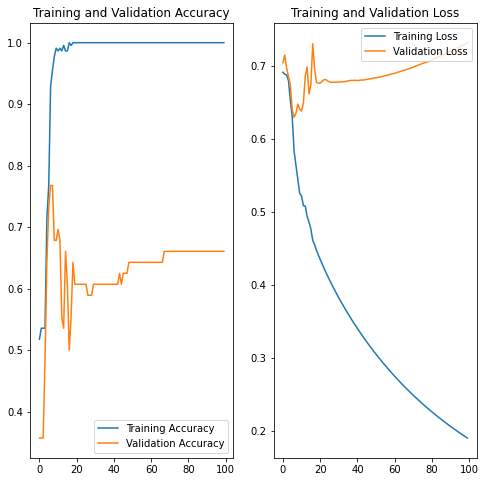

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [28]:
# Above graph indicates the sign of overfitting. Let's increase the dataset by augmentation

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal",
                                                    input_shape=(img_height,img_width,1)),
        layers.experimental.preprocessing.RandomFlip("vertical"),
#         layers.experimental.preprocessing.RandomRotation(0.1, input_shape=(img_height,img_width,1))
        layers.experimental.preprocessing.RandomRotation(0.1)
    ]
)

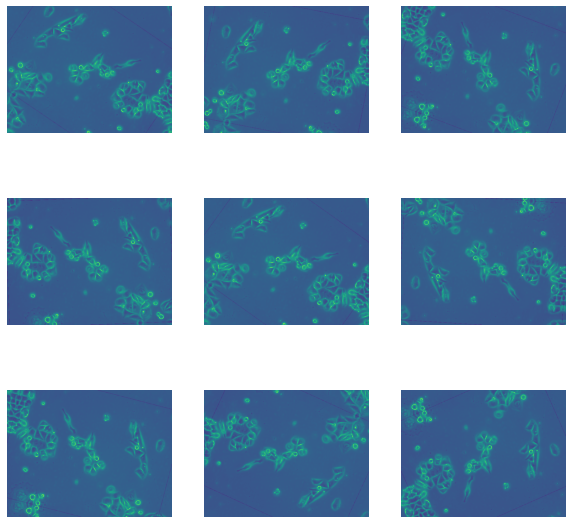

In [29]:
plt.figure(figsize=(10,10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax=plt.subplot(3,3,i+1)
        plt.imshow(augmented_images[0].numpy().astype('uint8'))
        plt.axis('off')

In [44]:
# Also, dropout technique helps reduce overfitting

# model = Sequential([
#     data_augmentation,
#     layers.experimental.preprocessing.Rescaling(1./255),
#     layers.Conv2D(16, 3, padding='same', activation='relu'),
#     layers.MaxPooling2D(),
# #     layers.Dropout(0.5), # newly added
#     layers.Conv2D(32, 3, padding='same', activation='relu'),
#     layers.MaxPooling2D(),
# #     layers.Dropout(0.5), # newly added
#     layers.Conv2D(64, 3, padding='same', activation='relu'),
#     layers.MaxPooling2D(),
#     layers.Dropout(0.2), # so far, 0.3 worked well
#     layers.Flatten(),
#     layers.Dense(64, activation='relu'), # or softmax # decreasing this layer no. causes overfitting?
#     layers.Dense(num_classes)
    
# ])

# test with more filters : 32-64-128
model = Sequential([
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
#     layers.Dropout(0.5), # newly added
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2), # newly added for test06
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2), # so far, 0.3 worked well
    layers.Flatten(),
    layers.Dense(512, activation='relu'), # or softmax
#     layers.Dense(512, activation='softmax'), # softmax failed
    layers.Dense(num_classes)
    
])

# perhaps we need smaller dense layer? (ucohead used 32)

In [45]:
model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [46]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 400, 518, 1)       0         
_________________________________________________________________
rescaling_6 (Rescaling)      (None, 400, 518, 1)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 400, 518, 32)      320       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 200, 259, 32)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 200, 259, 64)      18496     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 100, 129, 64)      0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 100, 129, 64)     

In [47]:
t1_start=process_time()

epochs = 100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

t1_stop=process_time()
print("Elapsed time: ", t1_stop, t1_start)
print("Time for total "+str(epochs) +" epochs : "+str((t1_stop-t1_start)/600) +" min.")

Epoch 1/100
7/7 [==============================] - 16s 2s/step - loss: 8.0798 - accuracy: 0.4911 - val_loss: 0.6936 - val_accuracy: 0.3571
Epoch 2/100
7/7 [==============================] - 16s 2s/step - loss: 0.6859 - accuracy: 0.5402 - val_loss: 0.6924 - val_accuracy: 0.6429
Epoch 3/100
7/7 [==============================] - 16s 2s/step - loss: 0.6868 - accuracy: 0.5357 - val_loss: 0.6928 - val_accuracy: 0.3929
Epoch 4/100
7/7 [==============================] - 16s 2s/step - loss: 0.6869 - accuracy: 0.5357 - val_loss: 0.6902 - val_accuracy: 0.6429
Epoch 5/100
7/7 [==============================] - 16s 2s/step - loss: 0.6880 - accuracy: 0.5357 - val_loss: 0.6903 - val_accuracy: 0.6429
Epoch 6/100
7/7 [==============================] - 16s 2s/step - loss: 0.6795 - accuracy: 0.5357 - val_loss: 0.6894 - val_accuracy: 0.6429
Epoch 7/100
7/7 [==============================] - 16s 2s/step - loss: 0.6828 - accuracy: 0.5357 - val_loss: 0.6873 - val_accuracy: 0.6429
Epoch 8/100
7/7 [==========

7/7 [==============================] - 16s 2s/step - loss: 0.3513 - accuracy: 0.8527 - val_loss: 0.3416 - val_accuracy: 0.8036
Epoch 60/100
7/7 [==============================] - 16s 2s/step - loss: 0.3717 - accuracy: 0.8304 - val_loss: 0.3587 - val_accuracy: 0.8214
Epoch 61/100
7/7 [==============================] - 16s 2s/step - loss: 0.3501 - accuracy: 0.8348 - val_loss: 0.3892 - val_accuracy: 0.8214
Epoch 62/100
7/7 [==============================] - 16s 2s/step - loss: 0.3476 - accuracy: 0.8571 - val_loss: 0.3846 - val_accuracy: 0.8750
Epoch 63/100
7/7 [==============================] - 16s 2s/step - loss: 0.3600 - accuracy: 0.8214 - val_loss: 0.3484 - val_accuracy: 0.7857
Epoch 64/100
7/7 [==============================] - 16s 2s/step - loss: 0.3163 - accuracy: 0.8705 - val_loss: 0.3385 - val_accuracy: 0.8036
Epoch 65/100
7/7 [==============================] - 16s 2s/step - loss: 0.3625 - accuracy: 0.8304 - val_loss: 0.3425 - val_accuracy: 0.7857
Epoch 66/100
7/7 [===============

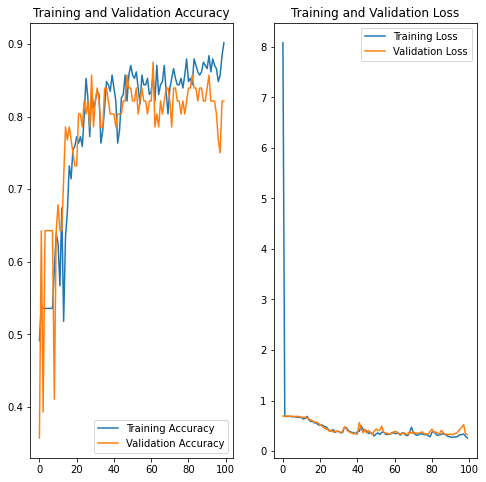

In [48]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [49]:
import pandas as pd
# df = pd.DataFrame(history)
# df.to_csv(index=False)
df = pd.DataFrame(history.history.values())
df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,8.079843,0.685920,0.686774,0.686912,0.688009,0.679469,0.682783,0.675131,0.671574,0.665850,...,0.278320,0.273048,0.281462,0.278118,0.300162,0.324753,0.327787,0.337467,0.295135,0.259413
1,0.491071,0.540179,0.535714,0.535714,0.535714,0.535714,0.535714,0.535714,0.589286,0.638393,...,0.866071,0.883929,0.861607,0.879464,0.870536,0.866071,0.848214,0.857143,0.883929,0.901786
2,0.693611,0.692354,0.692834,0.690199,0.690309,0.689351,0.687298,0.684861,0.690209,0.679511,...,0.341669,0.320878,0.345914,0.350230,0.387176,0.434671,0.477847,0.522719,0.343129,0.328143
3,0.357143,0.642857,0.392857,0.642857,0.642857,0.642857,0.642857,0.642857,0.410714,0.642857,...,0.839286,0.857143,0.821429,0.821429,0.821429,0.803571,0.767857,0.750000,0.821429,0.821429


In [50]:
df.to_csv('../test06_results.csv')

In [51]:
img = keras.preprocessing.image.load_img(
#       '../test_images/par1_early_008.jpg',
           '../test_images/par1_late_061.jpg',
#     '../test_images/wt_early_067.jpg', 
#     '../test_images/wt_late_048.jpg', 
    color_mode='grayscale', target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to par1 with a 75.01 percent confidence.
